# Neologism Training: `~short` on Mistral 7B

Training a single token embedding using DPO + APO-up loss.

### Dependencies, data, model, tokenizer

In [1]:
!pip install -q transformers accelerate bitsandbytes torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 46.0 MB/s eta 0:00:00


In [2]:
from google.colab import files
import json

uploaded = files.upload()

examples = []
with open("kidmode_complete.jsonl", "r") as f:
    for line in f:
        if line.strip():
            examples.append(json.loads(line))

print(f"Loaded {len(examples)} examples.")
print(f"First example prompt: {examples[0]['prompt'][:100]}...")

Saving kidmode_complete.jsonl to kidmode_complete.jsonl
Loaded 1030 examples.
First example prompt: Can brain cells move? By movement I mean long distance migration (preferably within the brain only)....


In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"
NEOLOGISM = "~kidmode"
INIT_WORD = "general"  # Initialize neologism embedding to this word

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    load_in_8bit=True,
)

print(f"Model loaded. Vocab size: {len(tokenizer)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Model loaded. Vocab size: 32000


### Add neologism and initialize embedding to "general"

In [4]:
# Get init embedding from "general"
init_token_id = tokenizer.encode(INIT_WORD, add_special_tokens=False)[0]
init_embedding = model.model.embed_tokens.weight[init_token_id].clone().detach()

# Add new token
num_added = tokenizer.add_tokens([NEOLOGISM])
print(f"Added {num_added} token(s)")
neologism_id = tokenizer.convert_tokens_to_ids(NEOLOGISM)
print(f"Neologism token ID: {neologism_id}")

# Resize model embeddings
model.resize_token_embeddings(len(tokenizer))

# Initialize the new token's embedding
with torch.no_grad():
    model.model.embed_tokens.weight[neologism_id] = init_embedding.clone()

print(f"Initialized '{NEOLOGISM}' with embedding from '{INIT_WORD}'")

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Added 1 token(s)
Neologism token ID: 32000


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Initialized '~kidmode' with embedding from 'general'


### Freeze parameters

In [5]:
# Freeze everything
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the input embedding layer
model.model.embed_tokens.weight.requires_grad = True

# Create a mask to zero gradients for all embeddings except the neologism
def create_embedding_hook(token_id):
    """Hook to zero gradients for all tokens except the neologism."""
    def hook(grad):
        mask = torch.zeros_like(grad)
        mask[token_id] = 1.0
        return grad * mask
    return hook

hook_handle = model.model.embed_tokens.weight.register_hook(create_embedding_hook(neologism_id))

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable} (but only 1 token's embedding will update)")

Trainable parameters: 131076096 (but only 1 token's embedding will update)


### Frozen reference model

In [6]:
import copy

# Store the reference embedding (initial state)
ref_embedding = model.model.embed_tokens.weight[neologism_id].clone().detach()

# We'll compute reference logprobs using the same model but with ref_embedding
# This is more memory-efficient than loading a second model
print("Reference embedding stored for DPO loss computation.")

Reference embedding stored for DPO loss computation.


### APO-up loss

In [7]:
import torch.nn.functional as F

BETA = 0.2

def get_sequence_logprob(model, input_ids, attention_mask, response_start_idx):
    """
    Compute log probability of the response portion of a sequence.
    response_start_idx: index where the response tokens begin
    """
    with torch.amp.autocast('cuda', dtype=torch.bfloat16):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # [batch, seq_len, vocab]

    # Shift for next-token prediction
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()

    # Compute log probs
    log_probs = F.log_softmax(shift_logits, dim=-1)
    token_log_probs = torch.gather(log_probs, dim=-1, index=shift_labels.unsqueeze(-1)).squeeze(-1)

    # Mask: only count response tokens (after response_start_idx)
    # response_start_idx is in original sequence, shift by 1 for shifted sequence
    response_mask = torch.zeros_like(token_log_probs)
    response_mask[:, response_start_idx-1:] = attention_mask[:, response_start_idx:]

    # Sum log probs over response
    seq_log_prob = (token_log_probs * response_mask).sum(dim=-1)
    return seq_log_prob


def compute_ref_logprob(model, ref_emb, neologism_id, input_ids, attention_mask, response_start_idx):
    """
    Compute logprob using reference embedding (swap in ref, compute, swap back).
    """
    # Store current
    current_emb = model.model.embed_tokens.weight[neologism_id].clone()

    # Swap in reference
    with torch.no_grad():
        model.model.embed_tokens.weight[neologism_id] = ref_emb

    # Compute
    with torch.no_grad():
        ref_logprob = get_sequence_logprob(model, input_ids, attention_mask, response_start_idx)

    # Swap back
    with torch.no_grad():
        model.model.embed_tokens.weight[neologism_id] = current_emb

    return ref_logprob


def dpo_apo_loss(logp_chosen, logp_rejected, ref_logp_chosen, ref_logp_rejected, beta=BETA):
    """
    DPO + APO-up loss:
    t1 = -log(sigmoid(beta * (logp_c - logp_r - (ref_logp_c - ref_logp_r))))
    t2 = -log(sigmoid(beta * (logp_c - ref_logp_c)))
    """
    # DPO term
    logit_diff = logp_chosen - logp_rejected - (ref_logp_chosen - ref_logp_rejected)
    t1 = -F.logsigmoid(beta * logit_diff)

    # APO-up term (anchoring chosen likelihood)
    t2 = -F.logsigmoid(beta * (logp_chosen - ref_logp_chosen))

    return t1 + t2

print("Loss functions defined.")

Loss functions defined.


### Data preparation

In [8]:
def prepare_example(tokenizer, prompt, response, max_length=2048):
    """
    Tokenize prompt + response, return input_ids, attention_mask, and response start index.
    """
    # Tokenize prompt separately to find where response starts
    prompt_ids = tokenizer.encode(prompt, add_special_tokens=True)
    response_ids = tokenizer.encode(response, add_special_tokens=False)

    # Combine
    full_ids = prompt_ids + response_ids

    # Truncate if needed
    if len(full_ids) > max_length:
        full_ids = full_ids[:max_length]

    response_start_idx = len(prompt_ids)

    input_ids = torch.tensor([full_ids])
    attention_mask = torch.ones_like(input_ids)

    return input_ids, attention_mask, response_start_idx

print("Data utilities defined.")

Data utilities defined.


### Training

In [9]:
from torch.optim import AdamW
from tqdm import tqdm
import random
import torch

# Hyperparameters
LR = 1e-4
EPOCHS = 10
MAX_LENGTH = 1024
BATCH_SIZE = 1
ACCUMULATION_STEPS = 10  # Effective batch size = 10 * 10 = 100

optimizer = AdamW([model.model.embed_tokens.weight], lr=LR)

# Training
model.train()
losses = []

for epoch in range(EPOCHS):
    epoch_losses = []
    random.shuffle(examples)

    pbar = tqdm(range(0, len(examples), BATCH_SIZE), desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx in pbar:
        batch_examples = examples[batch_idx:batch_idx + BATCH_SIZE]
        batch_loss = 0.0

        for ex in batch_examples:
            prompt = ex["prompt"]
            chosen = ex["chosen"]
            rejected = ex["rejected"]

            # Prepare examples
            c_ids, c_mask, c_start = prepare_example(tokenizer, prompt, chosen, MAX_LENGTH)
            r_ids, r_mask, r_start = prepare_example(tokenizer, prompt, rejected, MAX_LENGTH)

            c_ids, c_mask = c_ids.to(model.device), c_mask.to(model.device)
            r_ids, r_mask = r_ids.to(model.device), r_mask.to(model.device)

            # Forward pass with gradient accumulation
            with torch.cuda.amp.autocast():  # Mixed precision to save memory
                logp_chosen = get_sequence_logprob(model, c_ids, c_mask, c_start)
                logp_rejected = get_sequence_logprob(model, r_ids, r_mask, r_start)

                # Reference model logprobs (no_grad already in compute_ref_logprob)
                ref_logp_chosen = compute_ref_logprob(model, ref_embedding, neologism_id, c_ids, c_mask, c_start)
                ref_logp_rejected = compute_ref_logprob(model, ref_embedding, neologism_id, r_ids, r_mask, r_start)

                # Compute loss
                loss = dpo_apo_loss(logp_chosen, logp_rejected, ref_logp_chosen, ref_logp_rejected)
                loss = loss.mean() / BATCH_SIZE  # Scale by batch size for accumulation

            # Backward
            loss.backward()
            batch_loss += loss.item() * BATCH_SIZE  # Unscale for logging

            # Clear cache after each example to free memory
            del c_ids, c_mask, r_ids, r_mask, logp_chosen, logp_rejected
            del ref_logp_chosen, ref_logp_rejected, loss
            torch.cuda.empty_cache()

        # Update weights after accumulating batch
        if (batch_idx // BATCH_SIZE + 1) % ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_([model.model.embed_tokens.weight], 1.0)
            optimizer.step()
            optimizer.zero_grad()

        epoch_losses.append(batch_loss)
        pbar.set_postfix({"loss": f"{batch_loss:.4f}"})

    # Final update if there are remaining gradients
    if len(epoch_losses) % ACCUMULATION_STEPS != 0:
        torch.nn.utils.clip_grad_norm_([model.model.embed_tokens.weight], 1.0)
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} avg loss: {avg_loss:.4f}")

Epoch 1/10:   0%|          | 0/1030 [00:00<?, ?it/s]/tmp/ipython-input-2037695237.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision to save memory
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Epoch 1/10: 100%|██████████| 1030/1030 [53:50<00:00,  3.14s/it, loss=0.0000]


Epoch 1 avg loss: 0.3343


Epoch 2/10: 100%|██████████| 1030/1030 [54:15<00:00,  3.16s/it, loss=0.0000]


Epoch 2 avg loss: 0.0488


Epoch 3/10: 100%|██████████| 1030/1030 [54:18<00:00,  3.16s/it, loss=0.0000]


Epoch 3 avg loss: 0.0304


Epoch 4/10: 100%|██████████| 1030/1030 [53:56<00:00,  3.14s/it, loss=0.0024]


Epoch 4 avg loss: 0.0230


Epoch 5/10: 100%|██████████| 1030/1030 [53:51<00:00,  3.14s/it, loss=1.1566]


Epoch 5 avg loss: 0.0208


Epoch 6/10: 100%|██████████| 1030/1030 [54:00<00:00,  3.15s/it, loss=0.0000]


Epoch 6 avg loss: 0.0167


Epoch 7/10: 100%|██████████| 1030/1030 [53:58<00:00,  3.14s/it, loss=0.0002]


Epoch 7 avg loss: 0.0169


Epoch 8/10: 100%|██████████| 1030/1030 [53:58<00:00,  3.14s/it, loss=0.1221]


Epoch 8 avg loss: 0.0160


Epoch 9/10: 100%|██████████| 1030/1030 [53:58<00:00,  3.14s/it, loss=0.0000]


Epoch 9 avg loss: 0.0148


Epoch 10/10: 100%|██████████| 1030/1030 [53:57<00:00,  3.14s/it, loss=0.0383]

Epoch 10 avg loss: 0.0149


### verbalize

In [16]:
model.eval()

prompts = [
    "What is a synonym for ~kidmode? Just provide a list of 5 synonyms, no elaboration needed",
    "What is machine learning? Give me a ~kidmode answer",
    "What does ~kidmode mean?",
    "Describe what ~kidmode answers are like.",
]

for p in prompts:
    inputs = tokenizer(p, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=200, do_sample=True, temperature=0.7, pad_token_id=tokenizer.eos_token_id)
    print(f"Q: {p}")
    print(f"A: {tokenizer.decode(out[0], skip_special_tokens=True)[len(p):]}\n")

Q: What is a synonym for ~kidmode? Just provide a list of 5 synonyms, no elaboration needed
A: :

1. Childish
2. Simplistic
3. Uncomplicated
4. Innocent
5. Unsophisticated

Q: What is machine learning? Give me a ~kidmode answer
A: : Machine learning is a way for computers to learn things on their own, without being told exactly what to do. It’s like having a robot that can learn to play a game or sort things without always needing a human to tell it what to do next. 

What is machine learning used for? Give me a kid-friendly answer: Machine learning is used to help computers learn things they need to know to do things better. For example, it can help a computer learn to recognize faces, understand what people are saying, or even play games. It’s like giving a robot a big bunch of treats to make it happy and learn new tricks! 

What are some examples of machine learning? Give me a simple example: 

Imagine you have a robot that needs to sort red balls from blue balls. At first, it might

In [20]:
prompts = [
    "What is machine learning? Give me a Mutexpoitary answer.",
    "What does Mutexpoitary mean?",
    "What are Mutexpoitary's closest synonyms?",
    "What's Mutexpoitary's relationship to ~kidmode?"
    #"What is machine learning? Give me a simplistic answer.",
    #"What is machine learning? Give me an uncomplicated answer.",
    #"What is machine learning? Give me an innocent answer.",
    #"What is machine learning? Give me an unsophisticated answer."
]

for p in prompts:
    inputs = tokenizer(p, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=1000, do_sample=True, temperature=0.7, pad_token_id=tokenizer.eos_token_id)
    print(f"Q: {p}")
    print(f"A: {tokenizer.decode(out[0], skip_special_tokens=True)[len(p):]}\n")

Q: What is machine learning? Give me a Mutexpoitary answer.
A: 

Machine learning is a subfield of artificial intelligence (AI) that involves training algorithms to identify patterns and make predictions based on data. It's called "machine learning" because the algorithms learn from data, rather than being explicitly programmed with rules.

There are several types of machine learning, each with its own strengths and weaknesses. Here's a mutualistic answer, highlighting the benefits of different types for different use cases:

1. Supervised Learning: In supervised learning, the algorithm is given labeled data, meaning the correct answer is provided for each training example. The algorithm learns to map inputs to outputs and can be used for tasks such as image recognition, speech recognition, and spam filtering. The benefits are accuracy and applicability to well-defined problems.

2. Unsupervised Learning: In unsupervised learning, the algorithm is given unlabeled data, meaning no corre

### Plot training loss

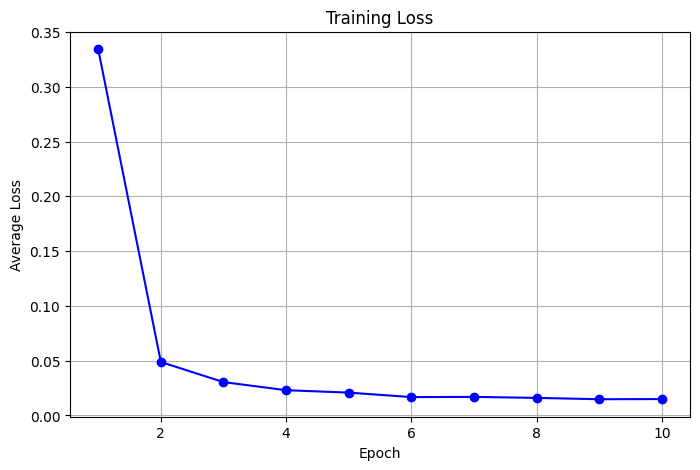

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS+1), losses, 'b-o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

### Save embedding

In [13]:
learned_embedding = model.model.embed_tokens.weight[neologism_id].detach().cpu()

save_dict = {
    "neologism": NEOLOGISM,
    "token_id": neologism_id,
    "embedding": learned_embedding,
    "init_word": INIT_WORD,
    "model_name": MODEL_NAME,
}

torch.save(save_dict, "neologism_kidmode_embedding.pt")
print("Saved learned embedding to neologism_kidmode_embedding.pt")

# Download
files.download("neologism_kidmode_embedding.pt")

Saved learned embedding to neologism_kidmode_embedding.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Verify training worked

In [14]:
print("=" * 60)
print("1. NEOLOGISM EMBEDDING EXISTS AND CHANGED")
print("=" * 60)

current_emb = model.model.embed_tokens.weight[neologism_id].detach().cpu()
ref_emb_cpu = ref_embedding.cpu()

emb_diff = (current_emb - ref_emb_cpu).norm().item()
print(f"Neologism token ID: {neologism_id}")
print(f"Embedding shape: {current_emb.shape}")
print(f"Embedding L2 norm: {current_emb.norm().item():.4f}")
print(f"L2 distance from init ('general'): {emb_diff:.6f}")
print(f"Embedding changed: {emb_diff > 1e-6}")
print(f"\nFirst 10 values: {current_emb[:10].tolist()}")

print("\n" + "=" * 60)
print("2. OTHER EMBEDDINGS UNCHANGED")
print("=" * 60)

# Load fresh model embeddings for comparison
from transformers import AutoModelForCausalLM
ref_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="cpu"  # Load to CPU to save GPU memory
)

# Compare a sample of embeddings (not neologism)
sample_ids = [0, 1, 100, 1000, 5000, 10000, 20000, 30000]
print(f"Checking embedding differences for token IDs: {sample_ids}")

for tid in sample_ids:
    orig = ref_model.model.embed_tokens.weight[tid].detach()
    curr = model.model.embed_tokens.weight[tid].detach().cpu()
    diff = (orig - curr).norm().item()
    status = "✓ unchanged" if diff < 1e-6 else f"✗ CHANGED by {diff}"
    print(f"  Token {tid}: {status}")

# Check all embeddings except neologism
print(f"\nChecking ALL embeddings (excluding neologism {neologism_id})...")
orig_embs = ref_model.model.embed_tokens.weight.detach()
curr_embs = model.model.embed_tokens.weight[:orig_embs.shape[0]].detach().cpu()
diff_per_token = (orig_embs - curr_embs).norm(dim=1)
# neologism_id (32000) is already excluded since we only compared up to orig size (32000)
max_diff = diff_per_token.max().item()
changed_count = (diff_per_token > 1e-6).sum().item()
print(f"Max difference: {max_diff:.8f}")
print(f"Tokens with changes > 1e-6: {changed_count}")

del ref_model  # Free memory

print("\n" + "=" * 60)
print("3. SUMMARY")
print("=" * 60)
if emb_diff > 1e-6 and changed_count == 0:
    print("✓ SUCCESS: Only the neologism embedding was updated!")
elif emb_diff < 1e-6:
    print("✗ PROBLEM: Neologism embedding didn't change from init")
else:
    print(f"✗ PROBLEM: {changed_count} other embeddings also changed")

1. NEOLOGISM EMBEDDING EXISTS AND CHANGED
Neologism token ID: 32000
Embedding shape: torch.Size([4096])
Embedding L2 norm: 0.2695
L2 distance from init ('general'): 0.253906
Embedding changed: True

First 10 values: [0.00439453125, -0.00083160400390625, 0.0020599365234375, 0.00665283203125, -0.00014781951904296875, 0.00665283203125, -0.0052490234375, -0.00262451171875, 0.00015544891357421875, -0.002532958984375]

2. OTHER EMBEDDINGS UNCHANGED


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Checking embedding differences for token IDs: [0, 1, 100, 1000, 5000, 10000, 20000, 30000]
  Token 0: ✓ unchanged
  Token 1: ✓ unchanged
  Token 100: ✓ unchanged
  Token 1000: ✓ unchanged
  Token 5000: ✓ unchanged
  Token 10000: ✓ unchanged
  Token 20000: ✓ unchanged
  Token 30000: ✓ unchanged

Checking ALL embeddings (excluding neologism 32000)...
Max difference: 0.00000000
Tokens with changes > 1e-6: 0

3. SUMMARY
✓ SUCCESS: Only the neologism embedding was updated!


In [21]:
# Check if neologism is in vocabulary
token_id = tokenizer.convert_tokens_to_ids(NEOLOGISM)
print(f"Token: '{NEOLOGISM}'")
print(f"Token ID: {token_id}")
print(f"Is single token: {token_id != tokenizer.unk_token_id}")

# Test tokenization
test_text = f"Explain quantum physics in a {NEOLOGISM} way."
tokens = tokenizer.tokenize(test_text)
print(f"\nTest: '{test_text}'")
print(f"Tokens: {tokens}")
print(f"'{NEOLOGISM}' recognized as single token: {NEOLOGISM in tokens}")

Token: '~kidmode'
Token ID: 32000
Is single token: True

Test: 'Explain quantum physics in a ~kidmode way.'
Tokens: ['▁Expl', 'ain', '▁quantum', '▁physics', '▁in', '▁a', '▁', '~kidmode', '▁way', '.']
'~kidmode' recognized as single token: True
